<a href="https://colab.research.google.com/github/nightmapleson/akagi/blob/master/UAV_Flight_Controller_Design.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# UAV Position Tracking with Kalman Filter

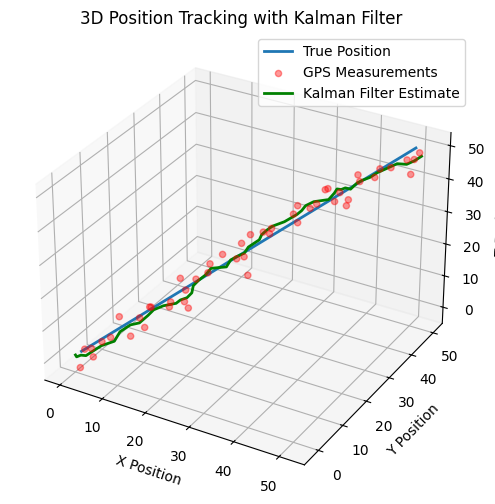

Sample Accelerometer Data: [array([ 0.15230299, -0.02341534, -0.0234137 ]), array([-0.05622875, -0.10128311,  0.03142473]), array([ 0.0375698 , -0.06006387, -0.02916937]), array([0.01968612, 0.07384666, 0.01713683]), array([-0.03850823, -0.0676922 ,  0.06116763])]
Sample Gyro Data: [array([ 0.01579213,  0.00767435, -0.00469474]), array([-0.00908024, -0.01412304,  0.01465649]), array([-0.00601707,  0.01852278, -0.00013497]), array([-0.00115648, -0.00301104, -0.01478522]), array([ 0.01031   ,  0.0093128 , -0.00839218])]
Sample Magnetometer Data: [array([ 1.027128  , -0.02317088, -0.02328649]), array([ 0.98871118,  0.00337641, -0.07123741]), array([ 0.94711445,  0.04112725, -0.06104218]), array([ 0.96400779, -0.02303194,  0.05285611]), array([0.98453938, 0.01656317, 0.04877726])]
Sample GPS Data: [[ 1.99342831  0.7234714   2.29537708]
 [ 2.48392454 -1.82656049 -1.44983567]
 [ 1.91123455  3.22184518  0.69801285]
 [ 4.41772719  0.08065975  1.3436279 ]
 [ 5.68723658  1.47391969  5.64816794]]

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import time

np.random.seed(42)               # 隨機種子碼
true_position = np.array([0,0,0])      # 初始位置
true_velocity = np.array([1,1,1,])      # 初始速度

# 三軸加速度計、三軸陀螺儀及磁力計模擬
true_acceleration = np.array([0, 0, 0])  # 假設無加速度
true_gyro = np.array([0, 0, 0])      # 假設無旋轉速率
true_magnetometer = np.array([1, 0, 0])  # 假設固定磁場方向

# GPS 模擬
true_gps_position = np.array([0, 0, 0])  # 初始 GPS 位置 (x, y, z)

# 模擬數據

time_steps = 50
true_positions = []
measurements = []
accelerometer_data = []
gyro_data = []
magnetometer_data = []
gps_data = []
gps_time_data = []
system_time_data = []

for t in range(time_steps):
    current_time = time.time()  # 記錄系統時間
    system_time_data.append(current_time)

    # 更新真實位置
    true_position += true_velocity
    true_positions.append(true_position.copy())

    # 模擬有雜訊的 GPS 測量
    gps_noise = np.random.normal(0, 2, 3)  # 假設 GPS 測量誤差標準差為 4
    gps_position = true_position + gps_noise
    gps_data.append(gps_position)
    gps_time_data.append(current_time)

    # 模擬加速度計數據
    accel_noise = np.random.normal(0, 0.1, 3)  # 假設加速度計誤差標準差為 0.1
    accelerometer_data.append(true_acceleration + accel_noise)

    # 模擬陀螺儀數據
    gyro_noise = np.random.normal(0, 0.01, 3)  # 假設陀螺儀誤差標準差為 0.01
    gyro_data.append(true_gyro + gyro_noise)

    # 模擬磁力計數據
    magnetometer_noise = np.random.normal(0, 0.05, 3)  # 假設磁力計誤差標準差為 0.05
    magnetometer_data.append(true_magnetometer + magnetometer_noise)

# 卡爾曼濾波器參數
state_estimate = np.zeros((6, 1))  # 初始狀態 [x, y, z, vx, vy, vz]
covariance_estimate = np.eye(6)  # 初始誤差協方差

state_transition = np.block([
    [np.eye(3), np.eye(3)],
    [np.zeros((3, 3)), np.eye(3)]
])  # 狀態轉移矩陣

observation_model = np.block([
    [np.eye(3), np.zeros((3, 3))]  # 只觀測位置 (x, y, z)
])

process_noise_covariance = np.eye(6) * 0.1  # 過程雜訊協方差
measurement_noise_covariance = np.eye(3) * 25  # GPS 測量雜訊協方差

kalman_positions = []

for gps_position in gps_data:
    z = gps_position.reshape((3, 1))  # 觀測值 (x, y, z)

    # 預測階段
    state_predict = np.dot(state_transition, state_estimate)
    covariance_predict = np.dot(np.dot(state_transition, covariance_estimate), state_transition.T) + process_noise_covariance

    # 更新階段
    kalman_gain = np.dot(
        np.dot(covariance_predict, observation_model.T),
        np.linalg.inv(np.dot(observation_model, np.dot(covariance_predict, observation_model.T)) + measurement_noise_covariance)
    )

    state_estimate = state_predict + np.dot(kalman_gain, (z - np.dot(observation_model, state_predict)))
    covariance_estimate = np.dot((np.eye(6) - np.dot(kalman_gain, observation_model)), covariance_predict)

    kalman_positions.append(state_estimate[:3].flatten())

# 繪圖
kalman_positions = np.array(kalman_positions)
true_positions = np.array(true_positions)
gps_data = np.array(gps_data)

fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, projection='3d')
ax.plot(true_positions[:, 0], true_positions[:, 1], true_positions[:, 2], label="True Position", linewidth=2)
ax.scatter(gps_data[:, 0], gps_data[:, 1], gps_data[:, 2], label="GPS Measurements", color="red", alpha=0.4)
ax.plot(kalman_positions[:, 0], kalman_positions[:, 1], kalman_positions[:, 2], label="Kalman Filter Estimate", linewidth=2, color="green")
ax.set_xlabel("X Position")
ax.set_ylabel("Y Position")
ax.set_zlabel("Z Position")
ax.set_title("3D Position Tracking with Kalman Filter")
ax.legend()
plt.show()

# 顯示加速度計、陀螺儀、磁力計及 GPS 模擬數據
print("Sample Accelerometer Data:", accelerometer_data[:5])
print("Sample Gyro Data:", gyro_data[:5])
print("Sample Magnetometer Data:", magnetometer_data[:5])
print("Sample GPS Data:", gps_data[:5])
print("Sample GPS Time Data:", gps_time_data[:5])
print("Sample System Time Data:", system_time_data[:5])

# Second Order System Transfer Function
###二階系統方程
1.$G(s)=\frac{ω^2_n}{s^2+ζω_ns+ω^2_n}$
  
    ω_n:自然頻率(rad/s)

    ζ：阻尼比




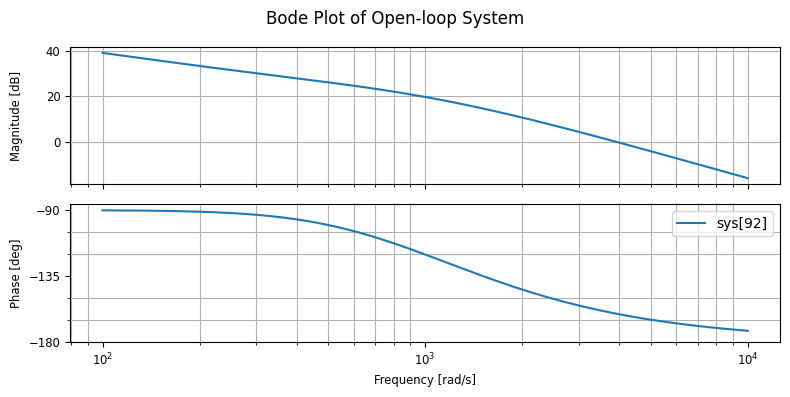

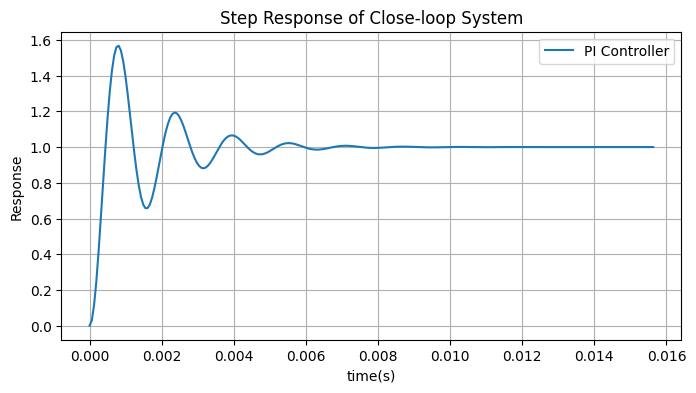

Proportional Gain (k_p):,20.0087
Integral Gain (k_i):8954.0588


In [ ]:
!pip install control
import numpy as np
import control as ctrl
import matplotlib.pyplot as plt

# Step 1:Given parameters from the second-order system
omega_n = 897.7   # 自然頻率(rad/s)
zeta = 1.003    # 阻尼比

# Step 2：Define the plant(second-order system)
num = [omega_n**2]  # Numerator ：Omega_n^2
den = [1,2*zeta*omega_n,omega_n**2] # Denominator：s^2+2*zeta*omega_n*s+omega_n^2
plant = ctrl.TransferFunction(num,den)

# Step 3: Design the PI controller
# PI Controller: K(s) = k_p + k_i / s
# Assume a target phase margin (PM) and gain crossover frequency (omega_g)
target_PM = 65  # Desired phase margin (degrees)
omega_g = 90   # Assumed gain crossover frequency

# Solve for k_p and k_i (based on frequency response and phase margin)
k_p = 2 * zeta * omega_n / omega_g  # Proportional gain (example calculation)
k_i = omega_n**2 / omega_g          # Integral gain

# Define the PI controller
PI_controller = ctrl.TransferFunction([k_p, k_i], [1, 0])

# Step 4: Combine the plant and controller
open_loop = PI_controller * plant
closed_loop = ctrl.feedback(open_loop)

# Step 5: Plot the frequency response(Bode plot)
plt.figure(figsize=(8,4))
ctrl.bode(open_loop ,dB = True)
plt.suptitle("Bode Plot of Open-loop System")
plt.grid()
plt.legend()
plt.show()

# Step 6:Simulate Step Response
plt.figure(figsize=(8,4))
time,response = ctrl.step_response(closed_loop)
plt.plot(time,response,label="PI Controller")
plt.title("Step Response of Close-loop System")
plt.xlabel("time(s)")
plt.ylabel("Response")
plt.grid()
plt.legend()
plt.show()

# Print Result
print(f"Proportional Gain (k_p):,{k_p:.4f}")
print(f"Integral Gain (k_i):{k_i:.4f}")

# 四元數(Quaternion)與旋轉矩陣(Rotation Matrix)

    * 四元數用於表示一物體在三維空間的旋轉狀態，比起旋轉矩陣轉換更為快速，並且可避免轉換時的方向死鎖。

    * 四元數可由一個實部與三個虛部組成，其在數學公式上可表示為：

        q = xi + yj + zk + w

      其中(x,y,z)為虛部，w為實部。虛部可表示為三維向量，而實部可看作是旋轉軸乘以旋轉角度。

    * 四元數與旋轉矩陣的轉換可由以下公式所得：

        R = | 1-2y^2-2z^2 2xy-2wz  2xz+2wy |
           | 2xy+2wz  1-2x^2-2z^2 2yz-2wx |
           | 2xz-2wy  2yz+2wx 1-2x^2-2y^2 |

    * 在python中可使用numpy.函式庫進行矩陣操作。若有一四元數q=[0.707,0.0,0.0,0.707]，可使用以下程式完成四元數-->旋轉矩陣之操作：
      from scipy.spatial.transform import Rotation as R

        def quaternion2rot(quaternion):
        r = R.from_quat(quaternion)
        rot_matrix = r.as_matrix()
        return rot_matrix

      quaternion = [0.707, 0.0, 0.0, 0.707]
      print(quatnion2rot(quatnion))

    * 運行後會獲得以下旋轉矩陣：
          ([ 1, 0, 0 ]
          [ 0, 0, -1 ]
          [ 0, 1, 0 ])

## 1.以旋轉向量旋轉矩陣

In [ ]:
import cv2
import numpy as np

def rotvector2rot(rotvector):
  Rm = cv2.Rodrigues(rotvector)[0]
  return Rm

rotvector = np.array([[0.0223680285784755, 0.240347886848190, 0.176566110650535]])
print(rotvector2rot(rotvector))


[[ 9.55859135e-01 -1.71277677e-01  2.38741012e-01]
 [ 1.76613834e-01  9.84279738e-01 -9.75111013e-04]
 [-2.34820926e-01  4.30970342e-02  9.71082787e-01]]


## 2.四元數 轉 歐拉角

In [ ]:
from scipy.spatial.transform import Rotation as R

def quaternion2euler(quaternion):
    r = R.from_quat(quaternion)
    euler_angle = r.as_euler('xyz', degrees=True)
    return euler_angle

quaternion = [0.03551, 0.21960, -0.96928, 0.10494]
print(quaternion2euler(quaternion))


[ -24.90053735    6.599459   -169.1003646 ]


## 3.歐拉角 轉 四元數

In [ ]:
from scipy.spatial.transform import Rotation as R

def quaternion2euler(euler_angle):
    r = R.from_euler('xyz', euler_angle, degrees=True)
    quaternion = r.as_quat()
    return quaternion
euler_angle = [-24.90053735, 6.599459, -169.1003646]
print(quaternion2euler(euler_angle))

[ 0.03550998  0.21959986 -0.9692794   0.10493993]


##4.歐拉角 轉 旋轉矩陣

In [ ]:
from scipy.spatial.transform import Rotation as R

def euler2rot(euler_angle):
    r = R.from_euler('xyz', euler_angle, degrees=True)
    rot_matrix = r.as_matrix()
    return rot_matrix

euler_angle = [-24.90053735, 6.599459, -169.1003646]
print(euler2rot(euler_angle))

[[-0.9754533   0.21902821 -0.02274859]
 [-0.18783626 -0.88152702 -0.43316008]
 [-0.11492777 -0.41825442  0.90102988]]


##5.旋轉矩陣 轉 歐拉角

In [ ]:
import numpy as np
import math

def isRotationMatrix(R):
  Rt = np.transpose(R)
  shouldBeIdentity = np.dot(Rt, R)
  I = np.identity(3, dtype=R.dtype)
  n = np.linalg.norm(I - shouldBeIdentity)
  return n < 1e-6

def rot2euler(R):
  assert(isRotationMatrix(R))

  sy = math.sqrt(R[0, 0] * R[0, 0] + R[1, 0] * R[1, 0])

  singular = sy < 1e-6

  if not singular:
    x = math.atan2(R[2,1],R[2,2])* 180 / np.pi
    y = math.atan2(-R[2,0],sy)* 180 / np.pi
    z = math.atan2(R[1,0],R[0,0])* 180 / np.pi
  else:
    x = math.atan2(-R[1,2],R[1,1])* 180 / np.pi
    y = math.atan2(-R[2,0],sy)* 180 / np
    z = 0

  return np.array([x,y,z])

rot = np.array([[-1.01749712e-02, 9.99670705e-01, -2.35574076e-02],
         [-9.99890780e-01, -1.04241019e-02, -1.04769347e-02],
         [-1.07190495e-02, 2.34482322e-02, 9.99667586e-01]])

print(rot2euler(rot))


[  1.34368509   0.61416806 -90.58302646]


##6.四元數 轉 旋轉矩陣

In [ ]:
from scipy.spatial.transform import Rotation as R

def quaternion2rot(quaternion):
    r = R.from_quat(quaternion)
    rot_matrix = r.as_matrix()
    return rot_matrix

quaternion = [0.03551, 0.21960, -0.96928, 0.10494]
print(quaternion2rot(quaternion))

[[-0.9754533   0.21902821 -0.02274859]
 [-0.18783626 -0.88152702 -0.43316008]
 [-0.11492777 -0.41825442  0.90102988]]


## 7.四元數旋轉應用

無人機轉換後的全域坐標: [107.07106781 207.07106781  50.        ]
目標點在全域坐標系的位置: [150, 220, 50]
無人機與目標點的相對座標: [42.92893219 12.92893219  0.        ]


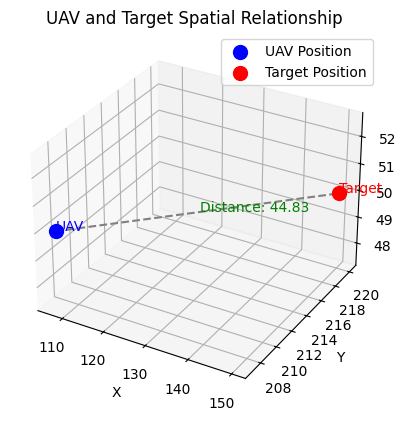

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.transform import Rotation as R

def quaternion_rotation(quaternion, body_coords):
    """
    將無人機體坐標系下的坐標轉換為全域坐標系。
    :param quaternion: 四元素 (x, y, z, w)，描述無人機姿態
    :param body_coords: 體坐標系下的座標 [x, y, z]
    :return: 全域坐標系下的坐標 [x, y, z]
    """
    # 創建旋轉物件
    r = R.from_quat(quaternion)

    # 進行座標轉換
    global_coords = r.apply(body_coords)

    return global_coords

def calculate_relative_coordinates(uav_global_position, target_global_position):
    """
    計算無人機與目標點之間的相對座標。
    :param uav_global_position: 無人機在全域坐標系的座標 [x, y, z]
    :param target_global_position: 目標點在全域坐標系的座標 [x, y, z]
    :return: 無人機與目標點之間的相對座標 [x, y, z]
    """
    relative_coords = np.array(target_global_position) - np.array(uav_global_position)
    return relative_coords

def plot_relationship(uav_position, target_position):
    """
    圖示無人機與目標點之間的空間關係。
    :param uav_position: 無人機的全域坐標位置 [x, y, z]
    :param target_position: 目標點的全域坐標位置 [x, y, z]
    """
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    # 畫出無人機的位置
    ax.scatter(*uav_position, c='blue', label='UAV Position', s=100)
    ax.text(*uav_position, "UAV", color='blue')

    # 畫出目標點的位置
    ax.scatter(*target_position, c='red', label='Target Position', s=100)
    ax.text(*target_position, "Target", color='red')

    # 畫出連線
    ax.plot([uav_position[0], target_position[0]],
            [uav_position[1], target_position[1]],
            [uav_position[2], target_position[2]], c='gray', linestyle='--')

    # 計算距離
    distance = np.linalg.norm(np.array(target_position) - np.array(uav_position))
    mid_point = [(uav_position[0] + target_position[0]) / 2,
                 (uav_position[1] + target_position[1]) / 2,
                 (uav_position[2] + target_position[2]) / 2]

    # 標示距離
    ax.text(*mid_point, f"Distance: {distance:.2f}", color='green')

    # 設定標籤與視角
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.set_title('UAV and Target Spatial Relationship')
    ax.legend()

    plt.show()

# 示例數據
if __name__ == "__main__":
    # 四元素 (x, y, z, w)：無人機姿態
    quaternion = [0, 0, np.sin(np.pi/8), np.cos(np.pi/8)]  # 假設旋轉 45 度（pi/4），分配給z軸

    # 無人機體坐標系下的座標 [x, y, z]
    body_coords = [10, 0, 0]  # 無人機前方 10 公尺

    # 將體坐標轉換到全域坐標系
    global_coords = quaternion_rotation(quaternion, body_coords)

    # 無人機在全域坐標系的位置
    uav_global_position = [100, 200, 50]  # 假設無人機位於全域坐標 [100, 200, 50]

    # 計算無人機轉換後的全域座標
    uav_global_coords = uav_global_position + np.array(global_coords)

    # 目標點在全域坐標系的位置
    target_global_position = [150, 220, 50]

    # 計算無人機與目標點之間的相對座標
    relative_coords = calculate_relative_coordinates(uav_global_coords, target_global_position)

    # 顯示結果
    print(f"無人機轉換後的全域坐標: {uav_global_coords}")
    print(f"目標點在全域坐標系的位置: {target_global_position}")
    print(f"無人機與目標點的相對座標: {relative_coords}")

    # 圖示無人機與目標物的空間關係
    plot_relationship(uav_global_coords, target_global_position)